# Baseline Recommender and Accuracy

## Import section

In [2]:
from data_gen import data_transform_split

In [3]:
import surprise
from surprise import Reader, Dataset, SVD
import numpy as np

In [4]:
from collections import defaultdict

In [5]:
trainset, testset = data_transform_split(0)

In [4]:
type(trainset)

surprise.trainset.Trainset

In [5]:
type(testset)

list

## Baseline Recommender Init and Setup

In [6]:
algo = SVD()

In [7]:
algo.fit(trainset)

In [8]:
predictions = algo.test(testset)

### Precision & Recall

In [23]:
def accuracy_precision_recall(predictions):
    '''
    Code copied from https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-compute-precision-k-and-recall-k and wrapped in outer function for slight modification
    '''
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""

        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():

            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                                  for (est, true_r) in user_ratings[:k])

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.

            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.

            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        return precisions, recalls
    # execute precision-recall function and compute average over precision and recall values
    precision_list, recall_list = precision_recall_at_k(predictions, k=100, threshold=0.5)
    p = sum(precision_list.values())/len(precision_list)
    r = sum(recall_list.values())/len(recall_list)
    return p, r

In [24]:
precision, recall = accuracy_precision_recall(predictions)

In [25]:
print("precision:", precision, "\nrecall:", recall)

precision: 0.26508770263742354 
recall: 0.23397106251391514


### ROC

In [50]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [37]:
def surpriselib_prediction_to_sklearn(predictions:list):
    # determine how many predictions we have and large the reserved arrays should be
    prediction_count = len(predictions)
    # initialize output parameters y_true and y_score
    y_true = np.zeros(shape=(prediction_count,))
    y_score = np.zeros(shape=(prediction_count,))
    # iterate over predictions and transform it into preallocated arrays
    for index, pred in enumerate(predictions):
        y_true[index]=int(pred.r_ui)
        y_score[index]=pred.est
    return y_true, y_score

In [1]:
def calc_and_plot_ROC(data_input, mode:int=0):
    '''
    Plot function for transfering the input data from surpriselib/pyg to sklearn and plot the roc
    
    Parameters
    ----------
    data_input : list of surpriselib Prediction Objects or pyg TODO
    mode : int
        Signals if the input is from surpriselib or pytorch geometric 0=Surpriselib, 1=pyg
    '''
    #asserting range of mode
    assert mode>=0
    assert mode<=1
    # initialize converted parameters
    y_true = None
    y_score = None
    # begin split into cases on how to convert the data
    if mode==0:
        # mode for surpriselib data
        # use separate function to convert surpriselib result data to sklearn usable variables
        y_true, y_score = surpriselib_prediction_to_sklearn(predictions)
    else:
        print("noch nicht implementiert")
        return
    # use sklearn to get fpr and tpr
    fpr, tpr, _ = metrics.roc_curve(y_true, y_score)
    # calculate the roc_auc (area under the curve)
    roc_auc = metrics.auc(fpr, tpr)
    # PLOT THE ROC CURVE
    '''
    Following code inspired/partly copied from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    '''
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", label="ROC curve (ROC AUC=%0.2f)" % roc_auc)
    plt.plot([0,1], [0,1], color="blue", linestyle="--")
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC CURVE")
    plt.legend(loc="lower right")
    plt.show()

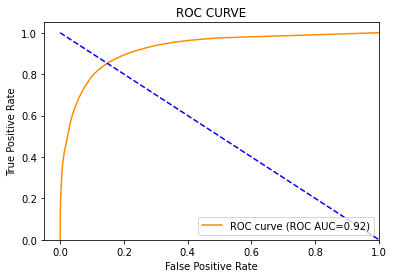

In [54]:
calc_and_plot_ROC(predictions)